In [1]:
import numpy as np
import math
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
class Network:

    def __init__(self) -> None:
        self.weights = []
        self.bias = []
        self.activations = []
        self.cache = []
        
    def add_layer(self, hidden_size, input_size=None, activation=1):
        if input_size==None:
            input_size = len(self.weights[-1])
        self.weights.append(np.random.normal(loc=0, scale=0.005, size=(hidden_size, input_size)))
        self.bias.append(np.array(hidden_size*[0], dtype=np.float32))
        self.activations.append(activation)


    def relu(self, Z):
        return np.maximum(Z, 0)
    
    def predict(self, input):
        return self.forward_propagation(input)
    
    def mse(self, y_true, y_pred):
        return np.mean(np.power(y_true-y_pred, 2))

    # forward propagation
    def forward_propagation(self, X):
        # retrieve the parameters
        self.cache = []
        X = X.astype(np.float32)
        for index in range(len(self.weights)):
            Z = np.dot(self.weights[index], X.T).T + self.bias[index]
            if self.activations[index] == 'relu':
                A = self.relu(Z)
            else:
                A = Z
            X = A
            self.cache.append({'Z': Z, 'A': A})
        return self.cache[-1]['A']
    
    def updateWeights(self, learning_rate):
        l = len(self.weights)
        for i in range(l):
            self.weights[i] = self.weights[i] - learning_rate*self.cache[i]['dw'].T
            self.bias[i] = self.bias[i] - learning_rate*self.cache[i]['db']
    
    def fit(self, X, Y, x_val, y_val, epochs, batch_size, learning_rate=0.001):
        for i in range(epochs):
            itr = len(X)//batch_size
            index = 0
            for _ in range(itr):
                x = X[index:index+batch_size]
                y = Y[index:index+batch_size]
                y = y.reshape(-1,1)
                index = index+batch_size
                self.forward_propagation(x)
                self.backprapogation(y)
                self.updateWeights(learning_rate)
                self.cache = []
            y_pred = self.predict(X)
            #print(y_pred[0])
            y_pred_val = self.predict(x_val)
            print('epoch',i,'completed', 'MSE: ', self.mse(Y, y_pred), 'Validation loss: ', self.mse(y_val, y_pred_val))


    def backprapogation(self, y):
        l = len(self.cache)
        a = y
        for i in range(l-1, -1, -1):
            if i == l-1:
                dz = 2*(self.cache[i]['A']-a)/len(a)
            else:
                dz = np.dot(a, self.weights[i+1]) * np.where(self.cache[i]['Z']>0, 1, 0)
            #print(self.cache[i-1]['A'].T.shape, dz.shape)
            n = dz.shape[0]
            self.cache[i]['dw'] = np.dot(self.cache[i-1]['A'].T, dz) #(1/n)*
            self.cache[i]['db'] = np.sum(dz, axis=0, keepdims=True) #2*(self.cache[i]['A']-a)*np.minimum(self.cache[i]['Z'], 1)
            #print(self.cache[i]['dw'])
            a = dz

In [4]:
X = np.concatenate((np.linspace(0.5, 100, 500), np.linspace(200,250,500)), axis=0)
Y = []
for i in X:
    Y.append(math.sqrt(i))
X = np.array(X).reshape(-1,1)
Y = np.array(Y)

In [5]:
indices = np.random.permutation(len(X))

# Shuffle X and Y using the permutation
X = X[indices]
Y = Y[indices]

In [3]:
model = Network()
model.add_layer(32, input_size=1, activation='relu')
model.add_layer(16, activation='relu')
model.add_layer(8, activation='relu')
model.add_layer(4, activation='relu')
model.add_layer(1)

In [4]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(1, 32),
      nn.ReLU(),
      nn.Linear(32, 16),
      nn.ReLU(),
      nn.Linear(16, 8),
      nn.ReLU(),
      nn.Linear(8, 4),
      nn.ReLU(),
      nn.Linear(4, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

In [5]:
kmodel = keras.Sequential([
    layers.Dense(32, kernel_initializer='he_normal', input_dim=1, activation='relu'),
    layers.Dense(16, kernel_initializer='he_normal', activation='relu'),
    layers.Dense(8, kernel_initializer='he_normal', activation='relu'),
    layers.Dense(4, kernel_initializer='he_normal', activation='relu'),
    layers.Dense(1, kernel_initializer='he_normal'),
    ])
kmodel.compile(loss='mse',
            optimizer=tf.keras.optimizers.legacy.SGD(0.001), metrics=['mean_absolute_percentage_error'])

Copying Keras model weight to custom model

In [6]:
l = len(model.weights)
for i, layer in enumerate(kmodel.layers):
    model.weights[i]= layer.get_weights()[0].T
    model.bias[i] = layer.get_weights()[1]

Model Weight distribution

In [7]:
weightsdf = []
for i in range(len(model.weights)):
    for w in model.weights[i].ravel():
        weightsdf.append({'weight': w})
weightsdf = pd.DataFrame(weightsdf)

In [8]:
weightsdf.describe()

,weight
count,708.000000
mean,-0.022084
std,0.382999
min,-2.417238
25%,-0.238518
50%,-0.013889
75%,0.193354
max,2.493237


/var/folders/3t/js5wz46s7yz41m_stlz72vn00000gp/T/ipykernel_78656/2794034409.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(weightsdf['weight'], kde = False, color ='red', bins = 30)


<Axes: xlabel='weight'>

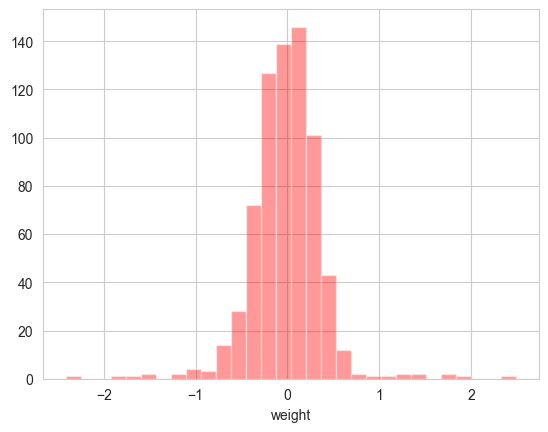

In [9]:
sns.set_style('whitegrid')
sns.distplot(weightsdf['weight'], kde = False, color ='red', bins = 30)

In [10]:
mlp = MLP()

In [11]:
# Define the loss function and optimizer
loss_function = nn.MSELoss() #mape_loss #nn.L1Loss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.001)

In [12]:
mlp.layers

Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=4, bias=True)
  (7): ReLU()
  (8): Linear(in_features=4, out_features=1, bias=True)
)

Copying custom neural network weight to pytorch model

In [13]:
with torch.no_grad():
    for i in [0,1,2,3,4]:
        mlp.layers[2*i].weight = nn.Parameter(torch.from_numpy(model.weights[i]).requires_grad_(True))
        mlp.layers[2*i].bias = nn.Parameter(torch.from_numpy(model.bias[i]).requires_grad_(True))


Initial weights of all the models (All have same weights)

In [14]:
mlp.layers[-1].weight

Parameter containing:
tensor([[-1.1920, -0.4745, -1.0694, -1.0544]], requires_grad=True)

In [15]:
mlp.layers[-1].bias

Parameter containing:
tensor([0.], requires_grad=True)

In [16]:
model.weights[-1].T

array([[-1.191985 ],
       [-0.4745204],
       [-1.0694414],
       [-1.0543547]], dtype=float32)

In [17]:
model.bias[-1]

array([0.], dtype=float32)

In [18]:
kmodel.layers[-1].get_weights()

[array([[-1.191985 ],
        [-0.4745204],
        [-1.0694414],
        [-1.0543547]], dtype=float32),
 array([0.], dtype=float32)]

Train pytorch with 1 epoach

In [19]:
class SqrtDataset(torch.utils.data.Dataset):
  '''
  Prepare the Poly dataset for regression
  '''

  def __init__(self, X, y, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

In [20]:
dataset = SqrtDataset(np.array([[4],[16],[25],[36]]), np.array([2,4,5,6]))
trainloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

In [21]:
loss_function = nn.MSELoss() #mape_loss #nn.L1Loss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.001)

In [22]:
for epoch in range(0, 1): # 5 epochs at maximum
    # Print epoch
    #print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
      # Get and prepare inputs
      inputs, targets = data
      inputs, targets = inputs.float(), targets.float()
      targets = targets.reshape((targets.shape[0], 1))
      
      # Zero the gradients
      optimizer.zero_grad()
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = loss_function(outputs, targets)
      
      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if epoch%10 == 0 and i>= 0 and i % 210 == 0:
          print('epoch: %d, Loss after mini-batch %5d: %.3f' %
                (epoch, i + 1, current_loss/(i+1)))
          current_loss = 0.0

epoch: 0, Loss after mini-batch     1: 28.985


Train Keras with 1 epoch

In [23]:
history = kmodel.fit(
    np.array([[4],[16],[25],[36]]), np.array([2,4,5,6]),validation_split=0,batch_size=4, shuffle=True,verbose=1, epochs=1)

1/1 [==============================] - 0s 225ms/step - loss: 28.9850 - mean_absolute_percentage_error: 116.3148


Custom model training with 1 epoach

In [24]:
model.predict(np.array([[4],[16],[25], [36]]))
model.backprapogation(np.array([[2],[4],[5],[6]]))
model.updateWeights(0.001)

Weights after 1 epoach (All the weights are same)

In [25]:
mlp.layers[-1].weight

Parameter containing:
tensor([[-1.1920, -0.4745, -1.0694, -1.0453]], requires_grad=True)

In [26]:
mlp.layers[-1].bias

Parameter containing:
tensor([0.0101], requires_grad=True)

In [27]:
kmodel.layers[-1].get_weights()

[array([[-1.191985 ],
        [-0.4745204],
        [-1.0694414],
        [-1.0453037]], dtype=float32),
 array([0.01005471], dtype=float32)]

In [28]:
model.weights[-1].T

array([[-1.19198501],
       [-0.47452039],
       [-1.06944144],
       [-1.0453037 ]])

In [29]:
model.bias[-1]

array([[0.0185346]])

In [ ]:
# history = kmodel.fit(
#     X, Y,validation_split=0.1,batch_size=10, shuffle=True,verbose=1, epochs=150)

In [36]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, Y, test_size=0.2, random_state=42)

In [ ]:
# model.fit(X_train, y_train, X_test, y_test, 30, 10, learning_rate=0.00005)

In [58]:
# model.cache[3]['A'].dtype

dtype('float32')

In [60]:
# kmodel.predict(np.array([[4],[16],[25], [36]])).tolist()

1/1 [==============================] - 0s 35ms/step


[[-0.19339026510715485],
 [-0.7481814026832581],
 [-1.16427481174469],
 [-1.6728323698043823]]

In [59]:
# model.predict(np.array([[4],[16],[25], [36]])).tolist()

[[-0.20718670853172735],
 [-0.8033677517014468],
 [-1.2505035340787378],
 [-1.79700282365098]]

In [ ]:
# model.predict(np.array([85]))

In [ ]:
# math.sqrt(85)

In [ ]:
# model.cache[4]['A']

In [ ]:
# model.cache[0]['A']

In [ ]:
# 1 2 3   4
# 2 3 4   5
# 3 4 5   6
# 4 5 6

# 1*4+2*5+3*6
# 2*4+3*5+4*6


In [34]:
# model.backprapogation(np.array([[9]]))
# model.updateWeights(0.001)

In [47]:
# model.backprapogation(np.array([[2],[4],[5], [6]]))
# model.updateWeights(0.001)

In [ ]:
# model.cache[2]['dw']

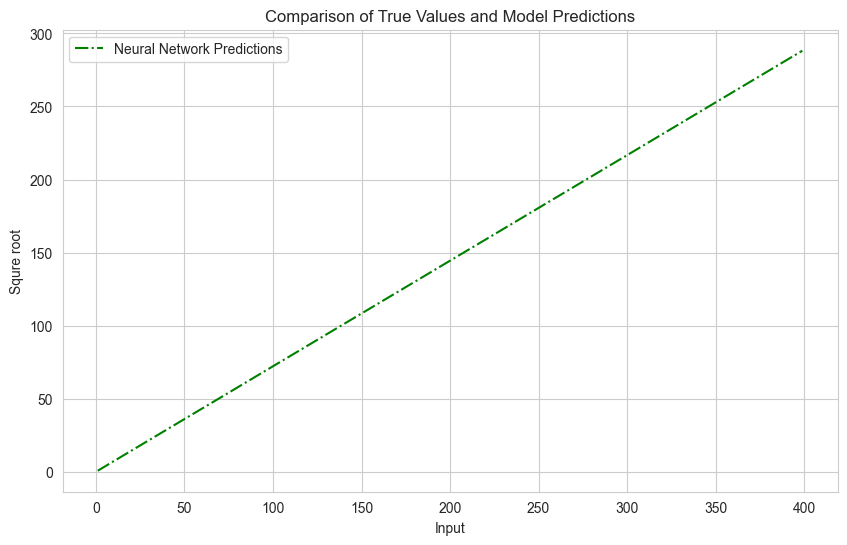

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
X_actual = np.array([i for i in range(1,400)])
Y_actual = [math.sqrt(i) for i in X_actual]
#Y_pred_rf = rf_model.predict(X_actual.reshape(-1,1))  # Predictions from random forest
Y_pred_nn = model.predict(X_actual.reshape(-1,1))  # Predictions from neural network

# Plot
plt.figure(figsize=(10, 6))

# Plot true values
#plt.plot(X_actual, Y_actual, color='black', linestyle='-', label='True Values')

# Plot Random Forest predictions
#plt.plot(X_actual, Y_pred_rf, color='blue', linestyle='--', label='Random Forest Predictions')

# Plot Neural Network predictions
plt.plot(X_actual, Y_pred_nn, color='green', linestyle='-.', label='Neural Network Predictions')

# Add labels and title
plt.xlabel('Input')
plt.ylabel('Squre root')
plt.title('Comparison of True Values and Model Predictions')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
X_actual = np.array([i for i in range(1,150)])
Y_actual = [math.sqrt(i) for i in X_actual]
#Y_pred_rf = rf_model.predict(X_actual.reshape(-1,1))  # Predictions from random forest
Y_pred_nn = model.predict(X_actual.reshape(-1,1))  # Predictions from neural network

# Plot
plt.figure(figsize=(10, 6))

# Plot true values
plt.plot(X_actual, Y_actual, color='black', linestyle='-', label='True Values')

# Plot Random Forest predictions
#plt.plot(X_actual, Y_pred_rf, color='blue', linestyle='--', label='Random Forest Predictions')

# Plot Neural Network predictions
plt.plot(X_actual, Y_pred_nn, color='green', linestyle='-.', label='Neural Network Predictions')

# Add labels and title
plt.xlabel('Input')
plt.ylabel('Squre root')
plt.title('Comparison of True Values and Model Predictions')
plt.legend()
plt.grid(True)

# Show plot
plt.show()
